# Lego Data Exploration

As a longtime Lego fan and peruser of the [Brickset](https://brickset.com/) fansite, I decided to see what interesting trends I could find in their comprehensive database. Over time, my interest in the monetary aspect of Lego has grown: How much do sets cost? Do they cost more nowadays compared to before? Does a given set cost more or less than average? What are the relevant variables for that calculation? (The inescapable question of why Lego is so expensive in general will be ignored, for my sanity.)

Lego also has a thriving secondary market, where certain retired sets [rack in absurd returns](https://www.catawiki.com/stories/715-top-10-most-expensive-lego-sets). My second step, after exploring the above questions, will be to bring in data for current secondary-market prices to build a model to predict which *current* sets might make money in the future. 



In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

%matplotlib inline
plt.rcParams['figure.dpi'] = 216
plt.style.use('fivethirtyeight')

## Preliminary questions
- Are longstanding current themes more likely to have a greater number of set releases per year?
- Has the price per piece increased over time? (Pick a specific theme, e.g. Star Wars)
    - Does this align with inflation? (Pick a specific currency)
- Are some themes more expensive than others? (Pick a specific year range)

In [170]:
curr_themes = ['Architecture', 'Brick Sketches', 'BrickHeadz', 'City', 'Classic', \
               'Collectable Minifigures', 'Creator', 'Creator Expert', 'DC Comics Super Heroes' \
                'Disney', 'DOTS', 'Duplo', 'Education', 'Friends', 'Harry Potter', \
               'Hidden Side', 'Ideas', 'Jurassic World', 'LEGO Art', 'Marvel Super Heroes', \
               'Mindstorms', 'Minecraft', 'Minions: The Rise of Gru', 'Monkie Kid', 'Ninjago' \
               'Overwatch', 'Powered Up', 'Speed Champions', 'Star Wars', 'Super Heroes', \
               'Super Mario', 'Technic ', 'Trolls World Tour']


data = pd.read_csv('allsets.csv')
print('Table has shape:', data.shape)
data.head()

Table has shape: (16806, 24)


,SetID,Number,Variant,ThemeGroup,Theme,SubTheme,Year,Name,Minifigs,Pieces,...,Image,ImageFilename,EAN,UPC,PackagingType,Availability,InstructionsCount,AdditionalImageCount,AgeMin,AgeMax
0,22667,001,1,Vintage themes,Samsonite,Basic Set,1965,Gears,NaN,43.0,...,True,001-1,NaN,NaN,Box,Retail,0,0,5.0,12.0
1,22683,1,3,Vintage themes,Samsonite,Basic Set,1967,Promotional Set No. 1 (Kraft Velveeta),NaN,74.0,...,True,1-3,NaN,NaN,Box,Promotional,0,0,NaN,NaN
2,7465,1,7,Basic,Universal Building Set,NaN,1973,Basic Set,NaN,107.0,...,True,1-7,NaN,NaN,{Not specified},{Not specified},0,0,NaN,NaN
3,7693,1,8,Vintage themes,Minitalia,NaN,1970,Small house set,NaN,67.0,...,True,1-8,NaN,NaN,{Not specified},{Not specified},0,0,NaN,NaN
4,22697,1,9,Basic,System,Basic Set,1969,Set No 1 - Quaker/Life Cereal,NaN,301.0,...,False,NaN,NaN,NaN,Box,{Not specified},0,0,NaN,NaN


## Visualizing numerical values: Year, Minifigs, Pieces, USRetailPrice

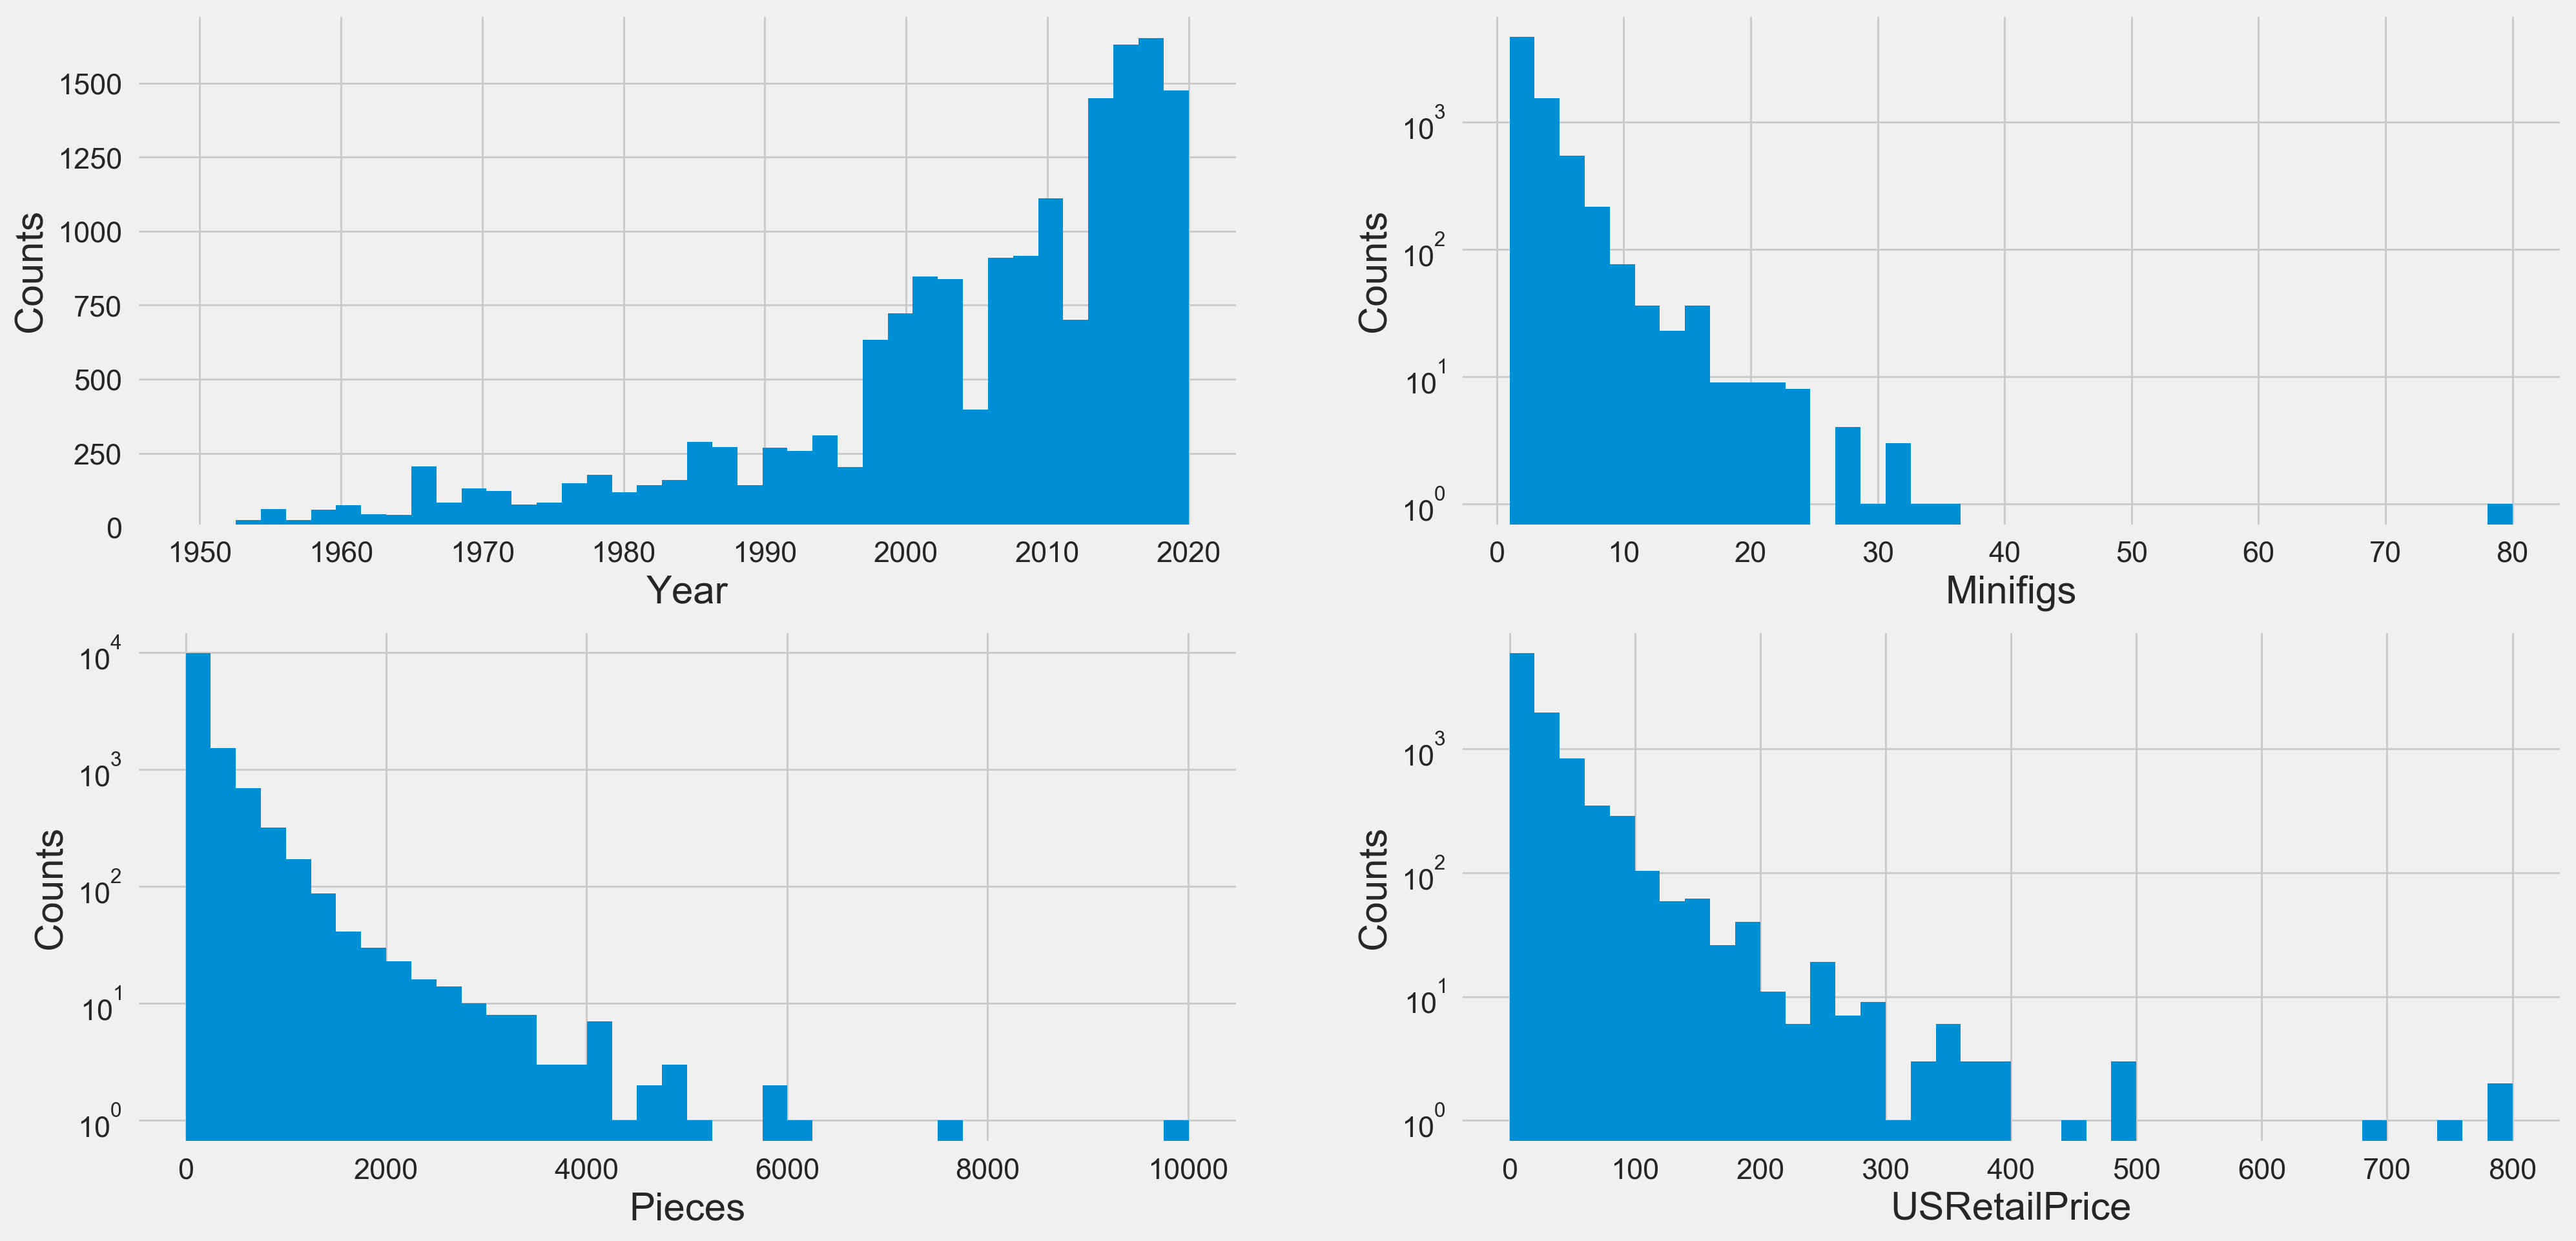

In [171]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
num_features = ['Year', 'Minifigs', 'Pieces', 'USRetailPrice'] # features of interest
axes = axes.ravel()
for i, ax in enumerate(axes):
    if i == 0:
        ax.hist(data[num_features[i]].dropna(), bins=40)
    else:
        ax.hist(data[num_features[i]].dropna(), bins=40, log=True)
    ax.set_xlabel(num_features[i], fontsize=20)
    ax.set_ylabel('Counts', fontsize=20)
    ax.tick_params(axis='both', labelsize=15)
fig.set_size_inches(20, 10)

A large amount of entries have no pieces (`NaN` or `0`, from looking at the CSV). Either they are not sets (e.g. books, pens, video games, etc.) or the data is incomplete. Regardless, we will discard them.

In [172]:
data = data[~(pd.isna(data['Pieces']) | (data['Pieces']==0))]
print('Table has shape:', data.shape)

Table has shape: (12811, 24)


## Visualizing categorical values: ThemeGroup

Text(0.5, 0, 'Count')

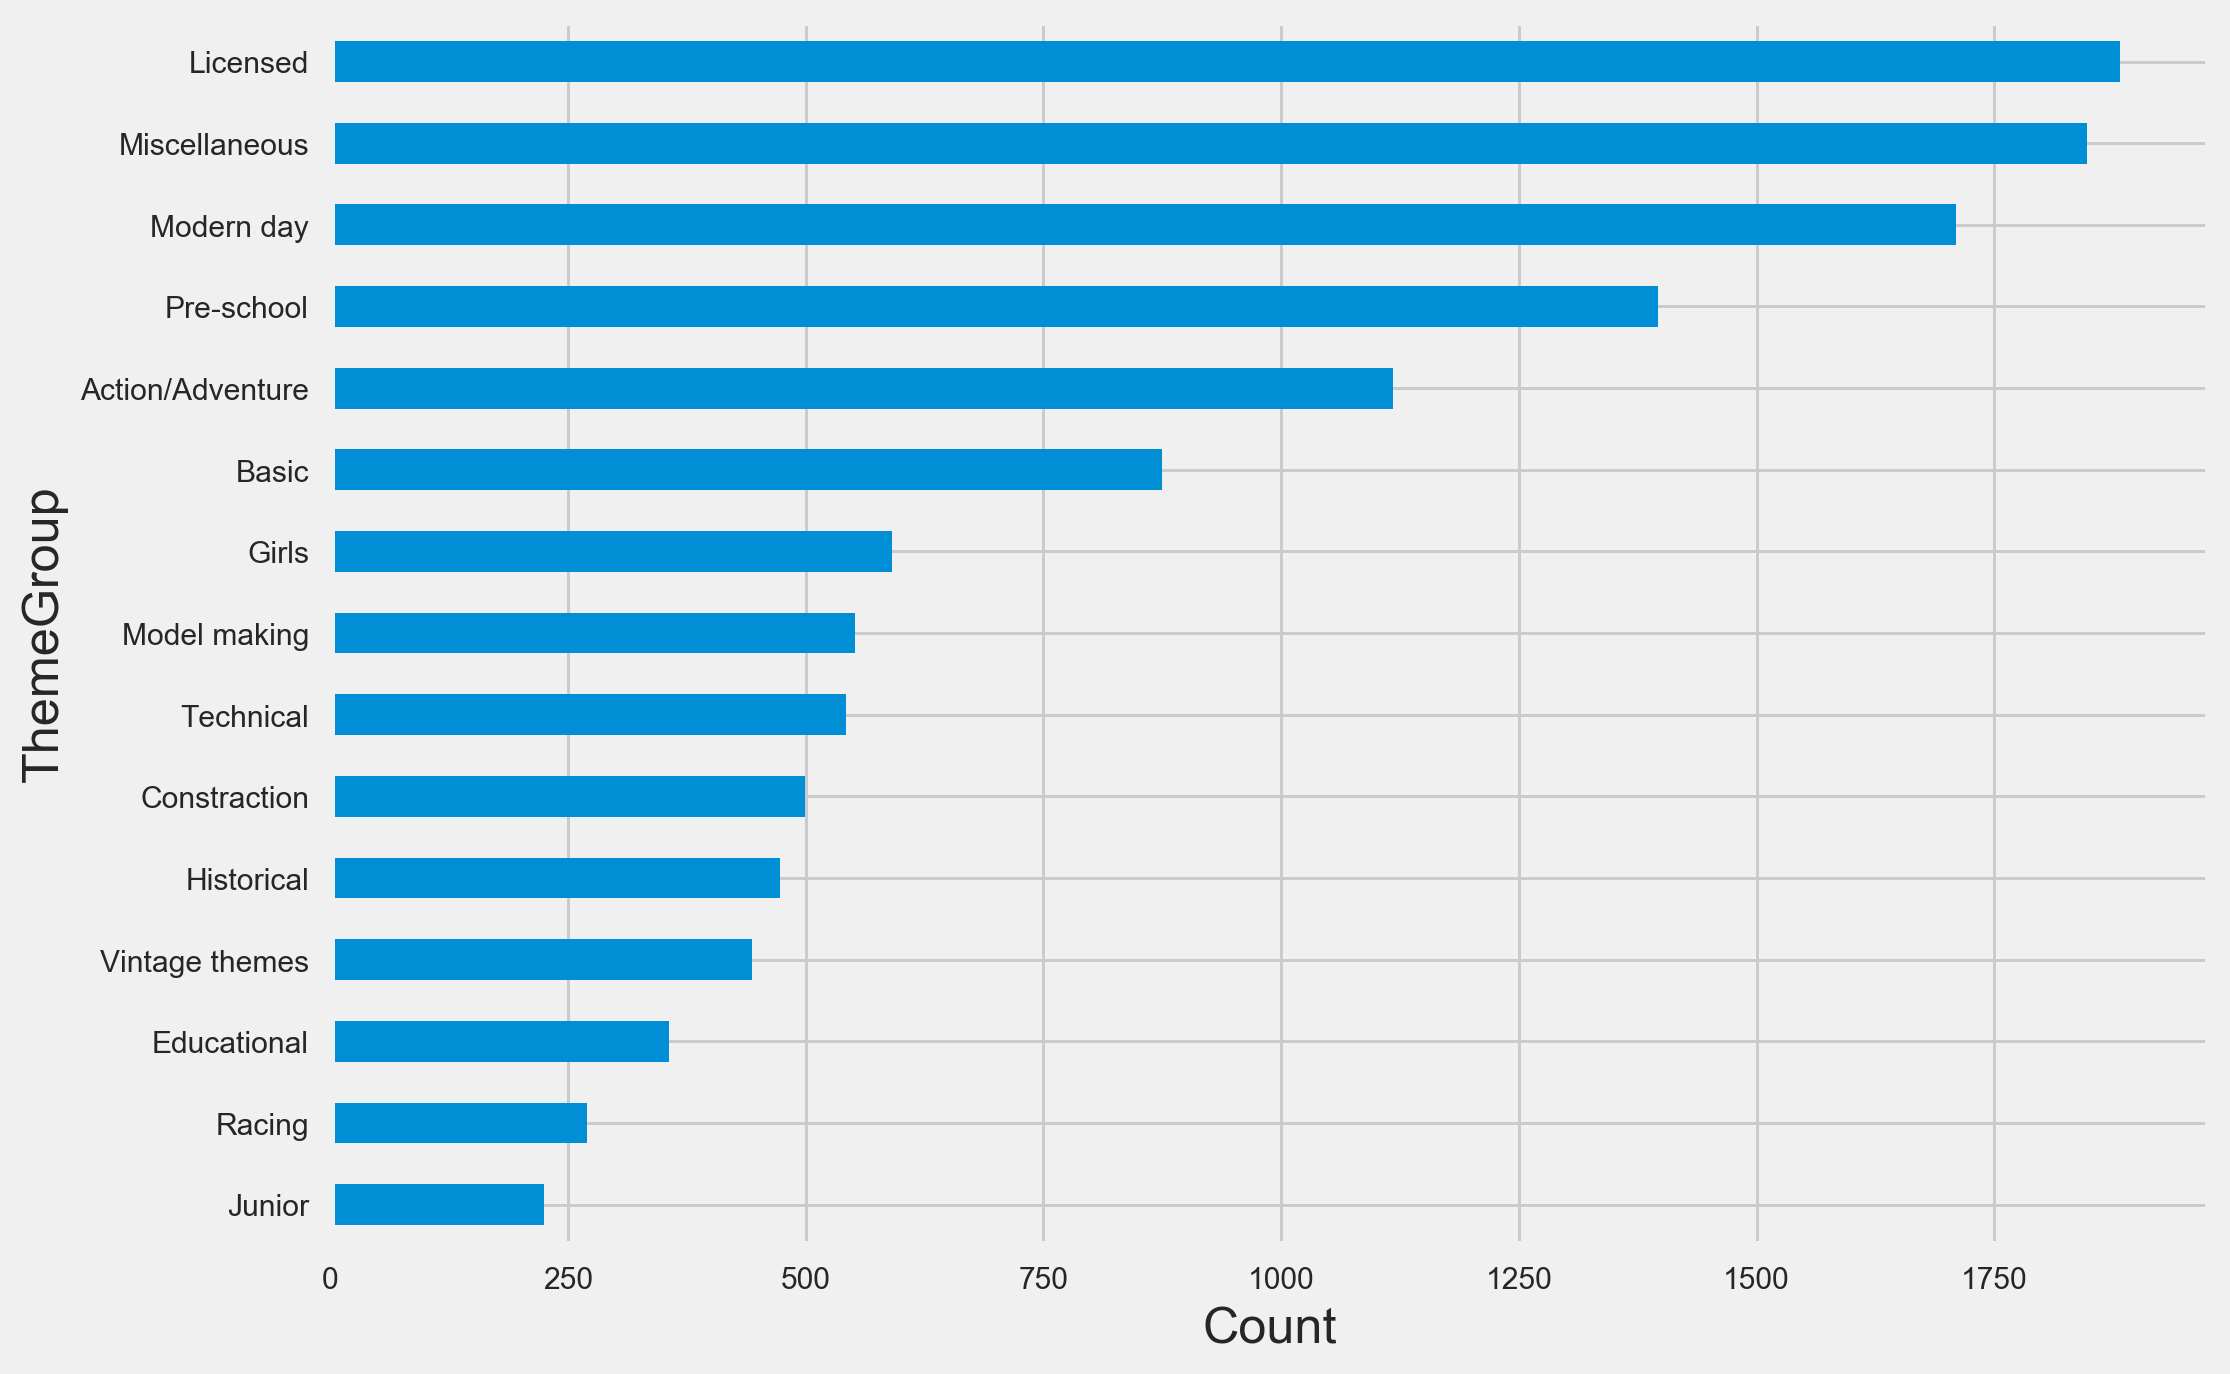

In [173]:
ax = data.groupby('ThemeGroup').size().sort_values().plot(kind='barh', figsize=(10,7))
ax.set_xlabel('Count')

## Are the numerical values correlated?

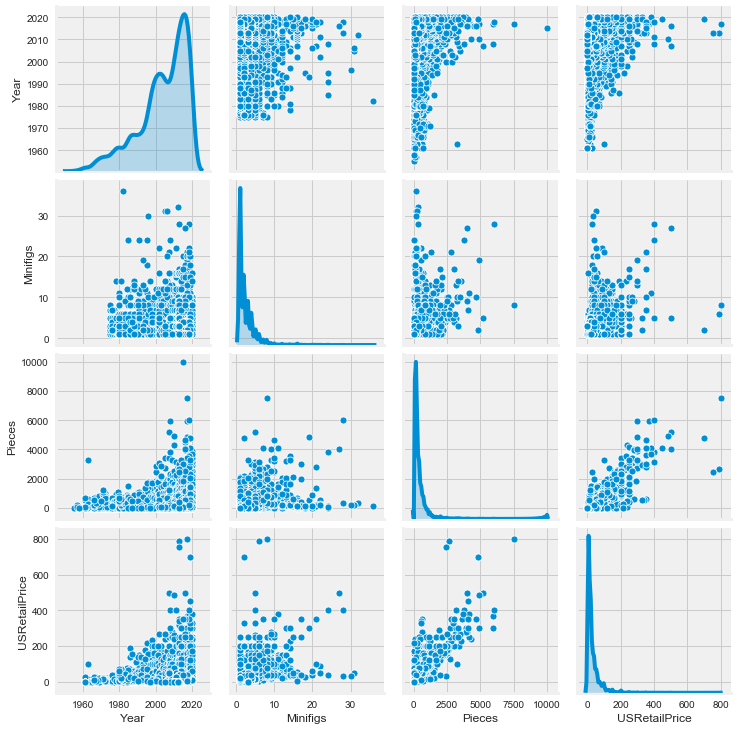

In [175]:
%matplotlib inline

import seaborn as sns
sns.pairplot(data[["Year", "Minifigs", "Pieces", "USRetailPrice"]], diag_kind="kde")

The most striking correlation is that the number of pieces is strongly correlated with price. In other words, larger sets tend to be more expensive.

More interestingly, there is a trend of sets getting bigger and more expensive over the years. Let's use the data to confirm this hypothesis.

## Has price per piece increased over time?

First, we'll look at the whole dataset. 

Since the first Lego themes were introduced in 1978, we must consider inflation--\\$1 in 1978 is worth more than \\$1 in 2020. Luckily, I found a [CSV file](https://www.in2013dollars.com/us/inflation/1978?amount=1) that lets us account for this.

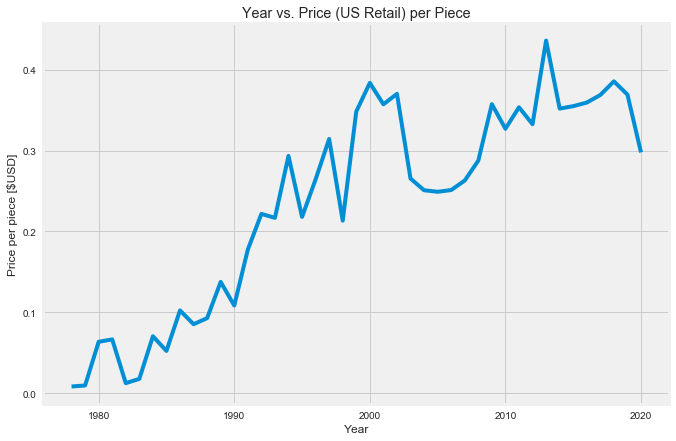

In [176]:
year_list = list(range(1978, 2021)) # The first Lego themes were introduced in 1978
inflation_data = pd.read_csv('inflation_data.csv')

def get_ppp_list_all(): # ppp = price per piece
    ppp_list = []
    for year in year_list:
        year_data = data[data['Year'] == year]
        total_price = year_data['USRetailPrice'].sum(axis='index')
        total_pieces = year_data['Pieces'].sum(axis='index')
        inflation_price = inflation_data[inflation_data['year'] == year]['amount'].iat[0]
        ppp = total_price / total_pieces * inflation_price
        if ppp == 0:
            ppp = np.nan
        ppp_list.append(ppp)        
    return ppp_list

ppp_list = get_ppp_list_all()

plt.figure(figsize=(10,7)) 
plt.xlabel('Year')
plt.ylabel('Price per piece [$USD]')
plt.title('Year vs. Price (US Retail) per Piece')
plt.plot(year_list, ppp_list, label='Average', linewidth=4)

The overall trend seems to be increasing. 

But some theme groups, such as Licensed, have a reputation in the Lego community for being more expensive than others. Let's see if this is true.


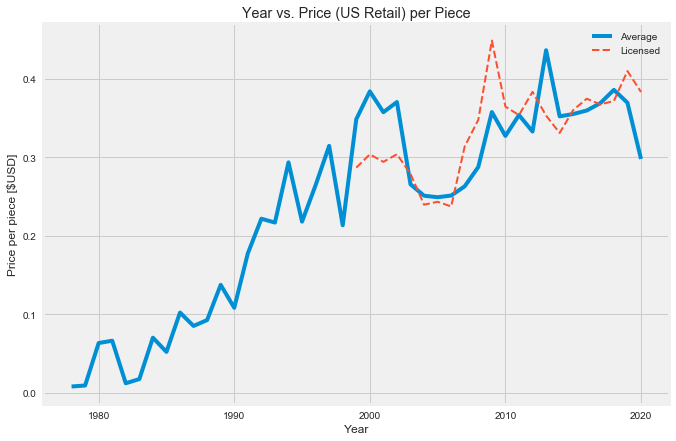

In [177]:
# theme_groups = ['Licensed', 'Miscellaneous', 'Modern day', 'Pre-school', 'Action/Adventure', \
#                 'Basic', 'Girls', 'Model making', 'Technical', 'Constraction', 'Historical', \
#                 'Vintage themes', 'Educational', 'Racing', 'Junior']

def plot_ppp_list(theme): 
    theme_data = data[data['ThemeGroup'] == theme]
    ppp_list = []
    for year in year_list:
        year_data = theme_data[theme_data['Year'] == year] # pandas df version of filter
        total_price = year_data['USRetailPrice'].sum(axis='index') # sum down the column
        total_pieces = year_data['Pieces'].sum(axis='index')
        inflation_price = inflation_data[inflation_data['year'] == year]['amount'].iat[0]
        if total_price == 0 or total_pieces == 0:
            ppp = np.nan
        else:
            ppp = total_price / total_pieces * inflation_price
        ppp_list.append(ppp)        
    plt.plot(year_list, ppp_list, label=theme, linestyle='--', linewidth=2)

plt.figure(figsize=(10,7)) 
plt.xlabel('Year')
plt.ylabel('Price per piece [$USD]')
plt.title('Year vs. Price (US Retail) per Piece')
plt.plot(year_list, ppp_list, label='Average', linewidth=4)
plot_ppp_list("Licensed")
plt.legend()


In 1999, the year of their introduction, Licensed sets start off significantly cheaper than average, but grow more expensive in the late 2000's. After 2010 they seem to be par for the course.

Let's plot a few more theme groups to compare.

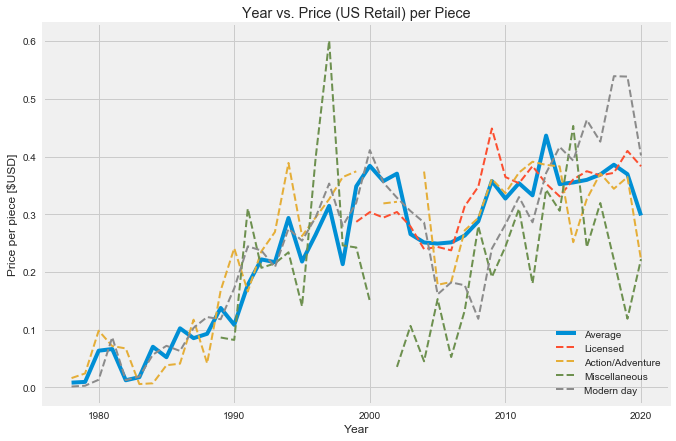

In [178]:
plt.figure(figsize=(10,7)) 
plt.xlabel('Year')
plt.ylabel('Price per piece [$USD]')
plt.title('Year vs. Price (US Retail) per Piece')
plt.plot(year_list, ppp_list, label='Average')
plot_ppp_list("Licensed")
plot_ppp_list("Action/Adventure")
plot_ppp_list("Miscellaneous")
plot_ppp_list("Modern day")
plt.legend()

What's responsible for the spike in Miscellaneous at 1997?

In [179]:
temp = data[(data['ThemeGroup'] == "Miscellaneous") & (data['Year'] == 1997)]
temp[['SetID', 'Theme', 'Year', 'Name', 'Pieces', 'USRetailPrice']]

,SetID,Theme,Year,Name,Pieces,USRetailPrice
1006,3739,Books,1997,Building Ideas Book,1.0,NaN
4378,2413,Service Packs,1997,"Duplo Start / Stop Rail, Single Rail, Change o...",4.0,NaN
4380,2415,Service Packs,1997,"Toolo Loader, Hook and Turntable",3.0,5.5
4554,2596,Service Packs,1997,Angle Bricks Assorted,20.0,4.0
4555,2597,Service Packs,1997,"Angle Beams, Red and Blue",8.0,4.0
4574,2617,Service Packs,1997,Fibre Optic Cables,8.0,3.0
4575,2618,Service Packs,1997,"Technic Beams and Plates with Holes, Black",26.0,4.5
4576,2619,Service Packs,1997,Technic Gear Wheels and Differential Housing,23.0,4.0
4704,2742,Service Packs,1997,Battery Box 9V For Electric System,1.0,5.0
4705,2743,Service Packs,1997,Western Accessories,34.0,5.0


It seems Service Packs are driving up the yearly average. For example, set 2742 (SetID) is a one piece battery that sold for \\$5. 

It isn't really a "set", per se, so given this and similar occurrences, it might be best to exclude the Miscellaneous theme entirely.

In [180]:
data = data[~(data['ThemeGroup'] == 'Miscellaneous')]
print('Table has shape:', data.shape)

Table has shape: (10964, 24)


## Price prediction models

### Regression using Year only

We'll first try linear reression.

In [183]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x = np.array(year_list).reshape((-1,1))
y = ppp_list
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)

r_sq = model.score(x,y)
r_sq

0.7925355382748327

The r^2 value is 0.79, which indicates a decent fit to the data. However, the price has been dropping in recent years, and there are peaks and troughs throughout the data. While we can say that the price generally increases in the long run, this simple model would fall short in making short-term predictions.

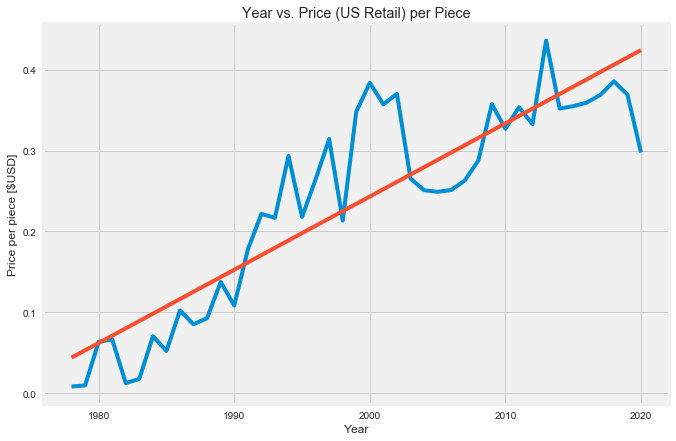

In [182]:
plt.figure(figsize=(10,7)) 
plt.xlabel('Year')
plt.ylabel('Price per piece [$USD]')
plt.title('Year vs. Price (US Retail) per Piece')
plt.plot(year_list, ppp_list, label='Average')
plt.plot(x, y_pred, linewidth=4)

### Regression using Year, Pieces, Minifigs, Theme

In [136]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [137]:
data['Theme'].isnull().values.any()

False

In [138]:
temp = data[['Year', 'Minifigs', 'Pieces','USRetailPrice']]
temp2 = pd.get_dummies(data['Theme']) # Turn Theme into a dummy variable
data_new = pd.concat([temp, temp2], axis=1)
# Drop NaN's and 0's for price
data_new = data_new[data_new['USRetailPrice'].notna() & (data_new['USRetailPrice'] != 0)] 
data_new = data_new.replace(np.nan, 0)

In [139]:
# Separate into training and testing sets
train_dataset = data_new.sample(frac=0.8,random_state=0)
test_dataset = data_new.drop(train_dataset.index)
train_stats = train_dataset.describe()
train_stats.pop('USRetailPrice')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Year,5604.0,2007.006781,10.800544,1961.0,2001.0,2009.0,2015.00,2020.0
Minifigs,5604.0,1.885082,2.532952,0.0,0.0,1.0,3.00,31.0
Pieces,5604.0,276.842077,450.820806,1.0,45.0,120.0,341.25,5923.0
4 Juniors,5604.0,0.002677,0.051672,0.0,0.0,0.0,0.00,1.0
Action Wheelers,5604.0,0.001428,0.037759,0.0,0.0,0.0,0.00,1.0
...,...,...,...,...,...,...,...,...
Vikings,5604.0,0.001071,0.032706,0.0,0.0,0.0,0.00,1.0
Western,5604.0,0.002855,0.053362,0.0,0.0,0.0,0.00,1.0
World City,5604.0,0.003034,0.054999,0.0,0.0,0.0,0.00,1.0
World Racers,5604.0,0.001428,0.037759,0.0,0.0,0.0,0.00,1.0


The features have significantly different ranges, so we should normalize them to avoid dependence on our choice of unit. 



In [140]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)

In [141]:
normed_train_data = train_dataset
normed_test_data = test_dataset

In [142]:
train_labels = train_dataset.pop('USRetailPrice')
test_labels = test_dataset.pop('USRetailPrice')

In [143]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
        optimizer='adam',
        metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                8448      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________


In [145]:
EPOCHS = 500

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=1,
#     callbacks=[tfdocs.modeling.EpochDots()]
)

Train on 4483 samples, validate on 1121 samples
Epoch 1/500
4483/4483 [==============================] - 2s 349us/sample - loss: 1412.5397 - mae: 19.5666 - mse: 1412.5399 - val_loss: 777.9973 - val_mae: 13.4946 - val_mse: 777.9973
Epoch 2/500
4483/4483 [==============================] - 1s 132us/sample - loss: 602.0853 - mae: 12.8676 - mse: 602.0856 - val_loss: 859.1434 - val_mae: 12.1756 - val_mse: 859.1434
Epoch 3/500
4483/4483 [==============================] - 1s 125us/sample - loss: 700.9036 - mae: 13.6630 - mse: 700.9039 - val_loss: 757.8252 - val_mae: 11.5434 - val_mse: 757.8251
Epoch 4/500
4483/4483 [==============================] - 1s 126us/sample - loss: 597.9164 - mae: 12.6614 - mse: 597.9164 - val_loss: 769.2237 - val_mae: 12.5513 - val_mse: 769.2239
Epoch 5/500
4483/4483 [==============================] - 1s 125us/sample - loss: 607.2388 - mae: 12.7343 - mse: 607.2387 - val_loss: 758.1914 - val_mae: 13.6364 - val_mse: 758.1915
Epoch 6/500
4483/4483 [======================

Epoch 45/500
4483/4483 [==============================] - 1s 121us/sample - loss: 526.1756 - mae: 11.0473 - mse: 526.1758 - val_loss: 726.0354 - val_mae: 12.4455 - val_mse: 726.0354
Epoch 46/500
4483/4483 [==============================] - 1s 115us/sample - loss: 512.5836 - mae: 10.7171 - mse: 512.5837 - val_loss: 735.7101 - val_mae: 12.3081 - val_mse: 735.7100
Epoch 47/500
4483/4483 [==============================] - 1s 129us/sample - loss: 532.3679 - mae: 10.9834 - mse: 532.3682 - val_loss: 711.8837 - val_mae: 12.3420 - val_mse: 711.8836
Epoch 48/500
4483/4483 [==============================] - 1s 127us/sample - loss: 514.3273 - mae: 10.6074 - mse: 514.3273 - val_loss: 730.8733 - val_mae: 10.2190 - val_mse: 730.8734
Epoch 49/500
4483/4483 [==============================] - 1s 135us/sample - loss: 512.0028 - mae: 10.6662 - mse: 512.0029 - val_loss: 712.1592 - val_mae: 11.9804 - val_mse: 712.1591
Epoch 50/500
4483/4483 [==============================] - 1s 116us/sample - loss: 523.8561

4483/4483 [==============================] - 1s 129us/sample - loss: 461.3904 - mae: 10.4037 - mse: 461.3904 - val_loss: 655.3881 - val_mae: 9.7858 - val_mse: 655.3881
Epoch 91/500
4483/4483 [==============================] - 1s 124us/sample - loss: 473.2303 - mae: 10.3164 - mse: 473.2303 - val_loss: 746.3696 - val_mae: 13.5689 - val_mse: 746.3698
Epoch 92/500
4483/4483 [==============================] - 1s 113us/sample - loss: 459.0203 - mae: 10.3474 - mse: 459.0203 - val_loss: 700.0084 - val_mae: 10.6233 - val_mse: 700.0084
Epoch 93/500
4483/4483 [==============================] - 1s 121us/sample - loss: 464.9764 - mae: 10.4371 - mse: 464.9764 - val_loss: 700.8451 - val_mae: 11.8768 - val_mse: 700.8450
Epoch 94/500
4483/4483 [==============================] - 1s 120us/sample - loss: 466.0193 - mae: 10.6712 - mse: 466.0192 - val_loss: 668.8160 - val_mae: 12.7599 - val_mse: 668.8159
Epoch 95/500
4483/4483 [==============================] - 1s 118us/sample - loss: 475.5548 - mae: 10.592

4483/4483 [==============================] - 1s 194us/sample - loss: 430.9305 - mae: 10.2814 - mse: 430.9305 - val_loss: 655.7833 - val_mae: 13.3039 - val_mse: 655.7833
Epoch 136/500
4483/4483 [==============================] - 1s 153us/sample - loss: 466.2495 - mae: 10.4864 - mse: 466.2495 - val_loss: 806.9088 - val_mae: 12.8152 - val_mse: 806.9087
Epoch 137/500
4483/4483 [==============================] - 1s 142us/sample - loss: 437.7289 - mae: 10.1074 - mse: 437.7289 - val_loss: 672.1415 - val_mae: 10.1543 - val_mse: 672.1416
Epoch 138/500
4483/4483 [==============================] - 1s 130us/sample - loss: 455.5119 - mae: 9.8363 - mse: 455.5120 - val_loss: 594.4057 - val_mae: 9.4459 - val_mse: 594.4056
Epoch 139/500
4483/4483 [==============================] - 1s 114us/sample - loss: 403.5965 - mae: 9.3340 - mse: 403.5964 - val_loss: 653.6396 - val_mae: 10.8089 - val_mse: 653.6396
Epoch 140/500
4483/4483 [==============================] - 1s 129us/sample - loss: 447.6461 - mae: 10.

4483/4483 [==============================] - 1s 155us/sample - loss: 403.2517 - mae: 9.4540 - mse: 403.2518 - val_loss: 590.2461 - val_mae: 10.0898 - val_mse: 590.2462
Epoch 181/500
4483/4483 [==============================] - 1s 120us/sample - loss: 384.6560 - mae: 9.3104 - mse: 384.6559 - val_loss: 591.4085 - val_mae: 10.1197 - val_mse: 591.4086
Epoch 182/500
4483/4483 [==============================] - 1s 145us/sample - loss: 409.7749 - mae: 9.6784 - mse: 409.7748 - val_loss: 654.0906 - val_mae: 10.1085 - val_mse: 654.0906
Epoch 183/500
4483/4483 [==============================] - 1s 129us/sample - loss: 459.4614 - mae: 10.3434 - mse: 459.4613 - val_loss: 590.6310 - val_mae: 9.4920 - val_mse: 590.6310
Epoch 184/500
4483/4483 [==============================] - 1s 115us/sample - loss: 391.7347 - mae: 9.0958 - mse: 391.7346 - val_loss: 599.7501 - val_mae: 9.3425 - val_mse: 599.7502
Epoch 185/500
4483/4483 [==============================] - 0s 106us/sample - loss: 381.6126 - mae: 9.0366

4483/4483 [==============================] - 1s 324us/sample - loss: 361.5433 - mae: 8.8694 - mse: 361.5433 - val_loss: 578.6725 - val_mae: 9.2239 - val_mse: 578.6727
Epoch 226/500
4483/4483 [==============================] - 1s 122us/sample - loss: 384.6571 - mae: 9.1281 - mse: 384.6571 - val_loss: 602.8811 - val_mae: 10.9810 - val_mse: 602.8811
Epoch 227/500
4483/4483 [==============================] - 0s 107us/sample - loss: 388.7864 - mae: 9.4271 - mse: 388.7863 - val_loss: 614.6467 - val_mae: 9.1882 - val_mse: 614.6467
Epoch 228/500
4483/4483 [==============================] - 0s 106us/sample - loss: 391.9814 - mae: 9.3783 - mse: 391.9813 - val_loss: 610.2061 - val_mae: 9.9473 - val_mse: 610.2062
Epoch 229/500
4483/4483 [==============================] - 0s 107us/sample - loss: 380.3871 - mae: 9.2983 - mse: 380.3871 - val_loss: 578.7470 - val_mae: 9.4991 - val_mse: 578.7470
Epoch 230/500
4483/4483 [==============================] - 0s 105us/sample - loss: 385.3069 - mae: 9.4306 - 

4483/4483 [==============================] - 0s 107us/sample - loss: 460.4777 - mae: 10.6435 - mse: 460.4776 - val_loss: 579.3882 - val_mae: 8.9546 - val_mse: 579.3882
Epoch 271/500
4483/4483 [==============================] - 0s 106us/sample - loss: 373.2521 - mae: 9.2251 - mse: 373.2521 - val_loss: 588.1275 - val_mae: 9.1560 - val_mse: 588.1275
Epoch 272/500
4483/4483 [==============================] - 0s 106us/sample - loss: 363.7055 - mae: 8.9675 - mse: 363.7056 - val_loss: 588.1985 - val_mae: 9.4404 - val_mse: 588.1984
Epoch 273/500
4483/4483 [==============================] - 0s 105us/sample - loss: 379.6903 - mae: 9.4466 - mse: 379.6904 - val_loss: 565.5526 - val_mae: 9.4420 - val_mse: 565.5526
Epoch 274/500
4483/4483 [==============================] - 0s 106us/sample - loss: 377.0810 - mae: 8.9726 - mse: 377.0810 - val_loss: 584.2462 - val_mae: 9.7460 - val_mse: 584.2463
Epoch 275/500
4483/4483 [==============================] - 0s 104us/sample - loss: 384.3989 - mae: 9.1319 - 

4483/4483 [==============================] - 1s 129us/sample - loss: 368.6763 - mae: 9.1357 - mse: 368.6763 - val_loss: 575.1968 - val_mae: 8.6934 - val_mse: 575.1968
Epoch 316/500
4483/4483 [==============================] - 1s 124us/sample - loss: 354.4991 - mae: 8.6958 - mse: 354.4991 - val_loss: 1065.8438 - val_mae: 20.6884 - val_mse: 1065.8438
Epoch 317/500
4483/4483 [==============================] - 1s 124us/sample - loss: 547.2029 - mae: 12.1741 - mse: 547.2029 - val_loss: 600.3530 - val_mae: 10.3463 - val_mse: 600.3530
Epoch 318/500
4483/4483 [==============================] - 1s 124us/sample - loss: 422.4760 - mae: 9.9992 - mse: 422.4759 - val_loss: 627.8861 - val_mae: 9.3421 - val_mse: 627.8861
Epoch 319/500
4483/4483 [==============================] - 1s 184us/sample - loss: 376.1820 - mae: 9.5146 - mse: 376.1820 - val_loss: 677.4757 - val_mae: 11.0563 - val_mse: 677.4756
Epoch 320/500
4483/4483 [==============================] - 1s 124us/sample - loss: 395.5000 - mae: 9.74

4483/4483 [==============================] - 0s 105us/sample - loss: 335.3856 - mae: 8.2714 - mse: 335.3855 - val_loss: 602.9549 - val_mae: 9.4260 - val_mse: 602.9548
Epoch 361/500
4483/4483 [==============================] - 0s 108us/sample - loss: 369.4551 - mae: 8.8075 - mse: 369.4551 - val_loss: 611.7500 - val_mae: 9.1891 - val_mse: 611.7500
Epoch 362/500
4483/4483 [==============================] - 0s 105us/sample - loss: 364.2712 - mae: 9.0667 - mse: 364.2711 - val_loss: 577.1910 - val_mae: 8.9519 - val_mse: 577.1910
Epoch 363/500
4483/4483 [==============================] - 0s 105us/sample - loss: 350.4878 - mae: 8.9517 - mse: 350.4878 - val_loss: 566.5686 - val_mae: 10.0306 - val_mse: 566.5686
Epoch 364/500
4483/4483 [==============================] - 0s 105us/sample - loss: 331.4528 - mae: 8.2684 - mse: 331.4528 - val_loss: 563.3998 - val_mae: 9.2468 - val_mse: 563.3998
Epoch 365/500
4483/4483 [==============================] - 0s 104us/sample - loss: 334.6740 - mae: 8.3238 - 

4483/4483 [==============================] - 1s 115us/sample - loss: 343.3945 - mae: 8.4408 - mse: 343.3945 - val_loss: 547.4408 - val_mae: 8.6907 - val_mse: 547.4409
Epoch 406/500
4483/4483 [==============================] - 0s 111us/sample - loss: 338.1214 - mae: 8.4044 - mse: 338.1215 - val_loss: 607.4417 - val_mae: 11.2711 - val_mse: 607.4418
Epoch 407/500
4483/4483 [==============================] - 0s 104us/sample - loss: 361.5150 - mae: 8.7726 - mse: 361.5150 - val_loss: 566.5593 - val_mae: 8.6467 - val_mse: 566.5594
Epoch 408/500
4483/4483 [==============================] - 0s 105us/sample - loss: 366.6878 - mae: 9.3369 - mse: 366.6878 - val_loss: 558.8038 - val_mae: 8.7530 - val_mse: 558.8038
Epoch 409/500
4483/4483 [==============================] - 0s 105us/sample - loss: 357.3494 - mae: 8.9328 - mse: 357.3493 - val_loss: 561.9759 - val_mae: 10.6865 - val_mse: 561.9758
Epoch 410/500
4483/4483 [==============================] - 0s 105us/sample - loss: 355.3643 - mae: 8.9949 -

4483/4483 [==============================] - 1s 122us/sample - loss: 353.7226 - mae: 8.5544 - mse: 353.7225 - val_loss: 562.3454 - val_mae: 9.7338 - val_mse: 562.3455
Epoch 451/500
4483/4483 [==============================] - 1s 121us/sample - loss: 375.0790 - mae: 9.0906 - mse: 375.0791 - val_loss: 612.0070 - val_mae: 11.8572 - val_mse: 612.0070
Epoch 452/500
4483/4483 [==============================] - 1s 118us/sample - loss: 341.1774 - mae: 8.7191 - mse: 341.1773 - val_loss: 580.8616 - val_mae: 10.7937 - val_mse: 580.8616
Epoch 453/500
4483/4483 [==============================] - 1s 124us/sample - loss: 356.9663 - mae: 8.7302 - mse: 356.9662 - val_loss: 613.2020 - val_mae: 11.8494 - val_mse: 613.2019
Epoch 454/500
4483/4483 [==============================] - 1s 158us/sample - loss: 355.3473 - mae: 8.8126 - mse: 355.3474 - val_loss: 558.1926 - val_mae: 9.5726 - val_mse: 558.1927
Epoch 455/500
4483/4483 [==============================] - 1s 179us/sample - loss: 338.5448 - mae: 8.2788 

4483/4483 [==============================] - 1s 122us/sample - loss: 330.6126 - mae: 8.3988 - mse: 330.6126 - val_loss: 536.8917 - val_mae: 8.4031 - val_mse: 536.8917
Epoch 496/500
4483/4483 [==============================] - 1s 129us/sample - loss: 336.2019 - mae: 8.3865 - mse: 336.2020 - val_loss: 652.3880 - val_mae: 12.4796 - val_mse: 652.3880
Epoch 497/500
4483/4483 [==============================] - 1s 121us/sample - loss: 416.4180 - mae: 9.7519 - mse: 416.4180 - val_loss: 531.6362 - val_mae: 8.5948 - val_mse: 531.6362
Epoch 498/500
4483/4483 [==============================] - 1s 130us/sample - loss: 341.7873 - mae: 8.4617 - mse: 341.7873 - val_loss: 546.5249 - val_mae: 9.3502 - val_mse: 546.5249
Epoch 499/500
4483/4483 [==============================] - 1s 177us/sample - loss: 328.9080 - mae: 8.1468 - mse: 328.9081 - val_loss: 544.2364 - val_mae: 8.5225 - val_mse: 544.2363
Epoch 500/500
4483/4483 [==============================] - 1s 161us/sample - loss: 330.6129 - mae: 8.4447 - 

Text(0, 0.5, 'MSE [USRetailPrice]')

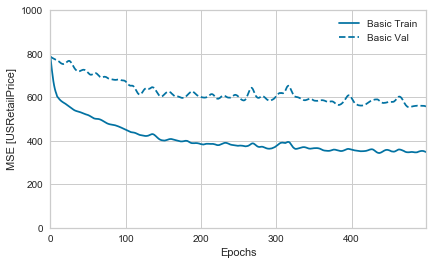

In [157]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 1000])
plt.ylabel('MSE [USRetailPrice]')

Text(0, 0.5, 'MAE [USRetailPrice]')

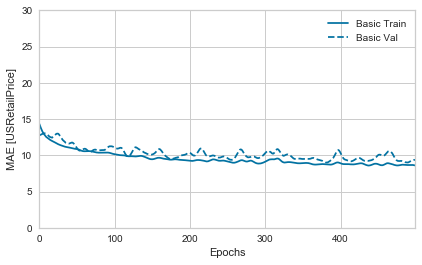

In [160]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 30])
plt.ylabel('MAE [USRetailPrice]')

In [166]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
mae

1401/1401 - 0s - loss: 313.5188 - mae: 9.3186 - mse: 313.5189


9.318588

Issues:
- MAE is \\$9.32 after one run, which is pretty high
- Normalizing doesn't seem to work
- Separate data exploration and model building into two notebooks, if GH pages allows